# **Introdução**

**Ideia Geral**

Utilizando os dados de câncer da FOSP, somente do tipo colorretal, serão utilizados quatro modelos de machine learning diferentes, com o intuito de testar diferentes tipos de algoritmo na classificação de sobrevida por cinco anos.

O label é 0 se o paciente não sobreviveu após cinco anos do diagnóstico e 1 se sobreviveu.

**Modelos de ML**

Foram escolhidos os modelos Naive Bayes, que utiliza o Teorema de Bayes para realizar as previsões, Random Forest, XGBoost e LightGBM, que utilizam os conceitos de árvores de decisão, além de bagging e boosting. Além disso, será testado um modelo de votação com os melhores classificadores obtidos, visando obter um algoritmo ainda mais acertivo.

**Validação dos modelos**

Para validar os modelos treinados foi utilizada primeiramente a matriz de confusão, sendo possível avaliar os acertos em ambas as classes. Para entender de houve overfitting nos modelos, foi utilizada a curva ROC para os conjuntos de treino e teste, comparando a métrica AUC entre ambos os conjuntos.

Por fim, os modelos Random Forest, XGBoost e LightGBM oferecem a possibilidade de saber quais foram as features mais importantes, ou seja, que mais influenciam na previsão das classes. Assim, foram mostradas duas maneiras diferentes de analisar a importância das variáveis de entrada, uma usando a própria função dos modelos e outra usando a biblioteca SHAP, que mostra a influência das features em ambas as classes.

In [ ]:
# Leitura dos dados
df = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/colorretal_sp_labels.csv')
df.head(3)

(31916, 37)


,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,...,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5,ESCOLARI_2
0,4,19,2,3538709,9,2,IV,IV,I,0,...,3538709,4985,4985,4951,0,0,1,1,1,4.0
1,9,19,1,3537107,2,2,IIIA,III,I,0,...,3509502,2680,2744,2674,1,1,1,1,1,4.0
2,4,19,1,3516200,9,2,IIB,II,F,0,...,3516200,4725,4734,4719,0,0,1,1,1,4.0


In [ ]:
# Valores faltantes
df.isna().sum().sort_values(ascending=False).head(6)

ESCOLARI     0
CONSDIAG     0
DIAGTRAT     0
ANODIAG      0
FAIXAETAR    0
DRS          0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df.corr()
abs(corr_matrix['vivo_ano5']).sort_values(ascending = False).head(20)

vivo_ano5       1.000000
ULTIDIAG        0.831968
ULTITRAT        0.829350
ULTICONS        0.829178
vivo_ano3       0.698727
vivo_ano1       0.369942
obito_cancer    0.365039
obito_geral     0.344902
ANODIAG         0.303518
CIRURGIA        0.166547
ULTINFO         0.155014
CATEATEND       0.141150
OUTROS          0.114849
IDADE           0.079483
DIAGPREV        0.043418
SEXO            0.034478
HORMONIO        0.031212
IBGEATEN        0.029063
RECNENHUM       0.028075
NENHUM          0.025816
Name: vivo_ano5, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df.vivo_ano5.value_counts()

0    23394
1     8522
Name: vivo_ano5, dtype: int64

## **DataFrame vivo_ano5**

Antes de realizar o pré-processamento dos dados é necessário filtrar os dados, de modo a retirar pacientes que não foram acompanhados por pelo menos **cinco anos** e que a última informação consta como vivos.

In [ ]:
# Dataset da sobrevida de cinco anos
df_ano5 = df[~((df.obito_geral == 0) & (df.vivo_ano5 == 0))].reset_index(drop=True)
df_ano5.shape

(23338, 37)

In [ ]:
df_ano5.head(3)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,...,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5,ESCOLARI_2
0,4,19,2,3538709,9,2,IV,IV,I,0,...,3538709,4985,4985,4951,0,0,1,1,1,4.0
1,9,19,1,3537107,2,2,IIIA,III,I,0,...,3509502,2680,2744,2674,1,1,1,1,1,4.0
2,4,19,1,3516200,9,2,IIB,II,F,0,...,3516200,4725,4734,4719,0,0,1,1,1,4.0


# **Análise - Sobrevida cinco anos**

## **Pré-processamento**

Como o dataset já foi limpo anteriormente, aqui na etapa de pré-processamento será realizada a divisão dos dados em treino e teste, fazer a codificação das colunas textuais para colunas numéricas e a normalização dos dados. Com isso, temos os dados prontos para o treinamento dos modelos de machine learning e consequentemente sua validação.

Primeiro serão definidas as colunas que não serão utilizadas como features, assim, foi escolhido manter a coluna `IDADE`, então a coluna `FAIXAETAR` será retirada. O mesmo ocorre com a coluna `EC`, retirando a coluna `ECGRUP`. Por fim, as outras colunas contidas na `list_drop` são possíveis saídas para os modelos, mas estamos interessados somente na sobrevida de cinco anos, por isso só ela será mantida como label e as outras serão retiradas.

In [ ]:
list_drop = ['FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 'obito_geral',
             'vivo_ano1', 'vivo_ano3', 'ULTINFO', 'obito_cancer', 'ECGRUP', 'ESCOLARI']

lb = 'vivo_ano5'

Uma função foi criada para realizar o pré-processamento inteiro, chamada `preprocessing`, internamente ela utiliza outras funções criadas que são: `get_train_test` (divide os dados em treino e teste), `train_preprocessing` (prepara os dados de treino) e `test_preprocessing` (prepara os dados de teste). 

> Mais detalhes em [funções]().

In [ ]:
X_train, X_test, y_train, y_test, feat_cols = preprocessing(df_ano5, list_drop, lb, 
                                                            random_state=seed,
                                                            balance_data=False,
                                                            encoder_type='LabelEncoder', 
                                                            norm_name='StandardScaler')

X_train = (17503, 25), X_test = (5835, 25)
y_train = (17503,), y_test = (5835,)


In [ ]:
y_train.value_counts(normalize=True)

0    0.634863
1    0.365137
Name: vivo_ano5, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.63479
1    0.36521
Name: vivo_ano5, dtype: float64

## **Treinamento e validação dos modelos de machine learning**

Depois das etapas de preparação, os dados estão prontos para serem utilizados nos modelos escolhidos.

### **Naive Bayes**

In [ ]:
# Criação e treinamento do modelo Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

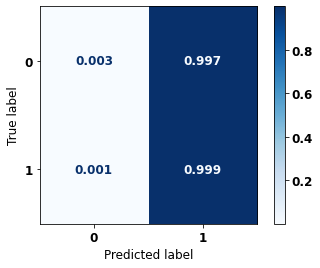


              precision    recall  f1-score   support

           0      0.769     0.003     0.005      3704
           1      0.366     0.999     0.535      2131

    accuracy                          0.366      5835
   macro avg      0.567     0.501     0.270      5835
weighted avg      0.622     0.366     0.199      5835



In [ ]:
# Matriz de confusão
plot_confusion_matrix(nb, X_test, y_test)

> Claramente percebe-se que o modelo previu quase todos os dados como sendo da classe 1, portanto não teve um aprendizado satisfatório. 

> Na matriz de confusão, buscamos uma diagonal principal equilibrada e com a maior acertividade possível.

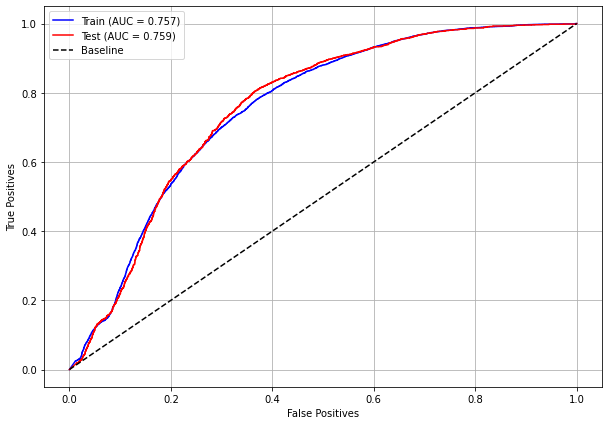

In [ ]:
# Curva ROC
plot_roc_curve(nb, X_train, X_test, y_train, y_test)

> Pelas curvas ROC, pode-se dizer que não há overfitting, mas o modelo é ruim para a previsão da classe 0, portanto qualquer análise além dessa não possui tanta relevância.

### **Random Forest**


O modelo Random Forest é mais complexo em relação ao Naive Bayes, assim alguns hiperparâmetros serão definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

* `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável `seed`.

* `max_depth`: será definido como 8, pois o padrão do modelo é não ter profundidade máxima para as árvores, o que dificulta e faz o treinamento ser muito longo, além da maior chance de overfitting.

* `class_weight`: usado para definir os pesos de cada classe no treinamento do modelo, muito útil quando temos classes desbalanceadas no conjunto de dados, como neste caso.

In [ ]:
# SP 
rf = RandomForestClassifier(random_state=seed, 
                            class_weight={0:1, 1:1.206},
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1.206}, criterion='entropy',
                       max_depth=8, random_state=10)

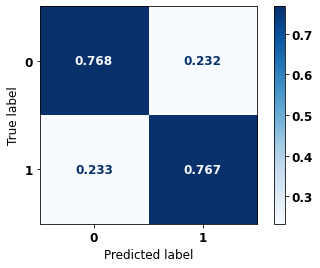


              precision    recall  f1-score   support

           0      0.851     0.768     0.807      3704
           1      0.655     0.767     0.707      2131

    accuracy                          0.767      5835
   macro avg      0.753     0.767     0.757      5835
weighted avg      0.780     0.767     0.771      5835



In [ ]:
plot_confusion_matrix(rf, X_test, y_test)

> A matriz obtida para o modelo Random Forest apresentou diagonal equilibrada em ambas as classes, com 77% de acurácia.


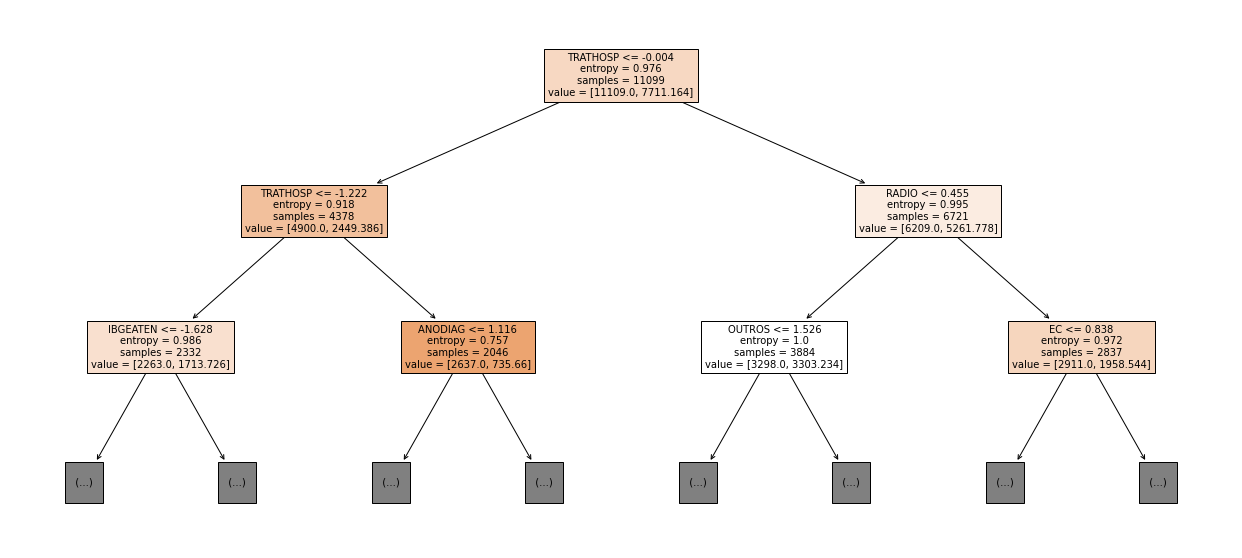

In [ ]:
show_tree(rf, feat_cols, 2)

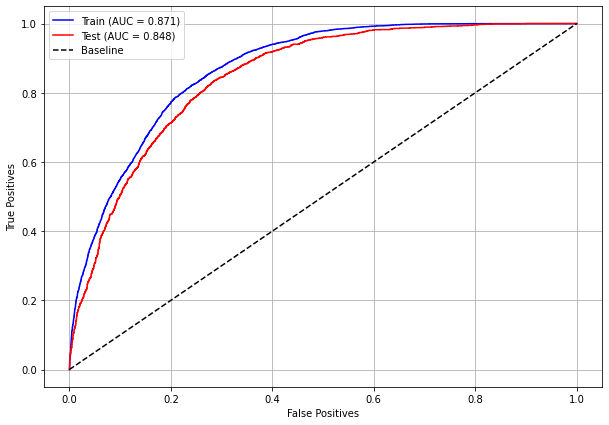

In [ ]:
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, 0,871 e 0,848 respectivamente, pode-se dizer que há apenas um pouco de overfitting, não sendo algo de grande preocupação.

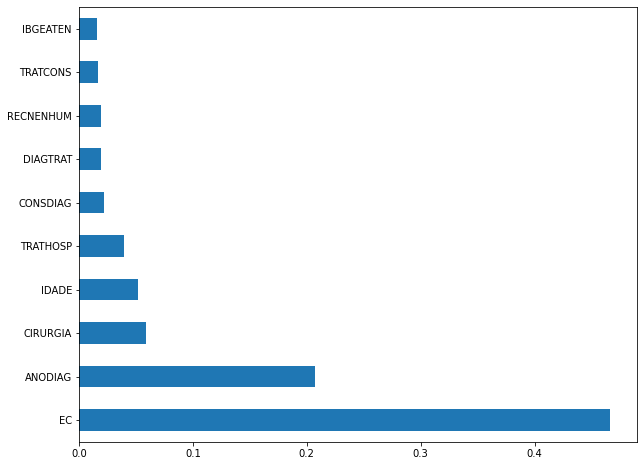

In [ ]:
plot_feat_importances(rf, feat_cols)

> As features mais importantes nesta visualização são `EC`, com uma grande vantagem, `ANODIAG`, `CIRURGIA` e `IDADE`. 

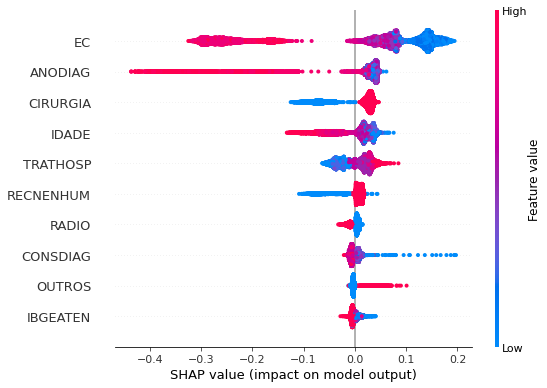

In [ ]:
plot_shap_values(rf, X_train, feat_cols)

A coluna `EC` foi a mais importante, com isso, os valores mais altos desta variável, mostrados em rosa, influenciaram mais o modelo na previsão da classe 0 (não sobreviveu ao quinto ano após o diagnóstico). Já os valores mais baixos desta coluna, em azul, tem mais peso para previsão ser da classe 1. Este comportamento faz sentido, pois quanto mais alto o estágio, maior é a extensão do câncer, assim menor a chance de sobrevivência.

O raciocínio para analisar as outras colunas é o mesmo utilizado para o estadiamento clínico.

#### Optuna

Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [ ]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples, 
                                 criterion=optimizer,
                                 random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100)

In [ ]:
# Melhor tentativa
print(f'The best trial is: \n{studyRF.best_trial}')

The best trial is: 
FrozenTrial(number=84, state=TrialState.COMPLETE, values=[0.7525312729217559], datetime_start=datetime.datetime(2023, 1, 20, 18, 12, 52, 129744), datetime_complete=datetime.datetime(2023, 1, 20, 18, 13, 12, 294149), params={'n_estimators': 110, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.7, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=84, value=None)


In [ ]:
# Melhor score
print(f'The best value is: \n{studyRF.best_value}')

# Melhores parâmetros
print(f'The best parameters are: \n{studyRF.best_params}')

The best value is: 
0.7525312729217559
The best parameters are: 
{'n_estimators': 110, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.7, 'criterion': 'gini'}


In [ ]:
plot_optimization_history(studyRF).show()

In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0: 1, 1: 1.76}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1.76}, max_depth=15,
                       max_samples=0.7, min_samples_split=4, n_estimators=110,
                       random_state=10)

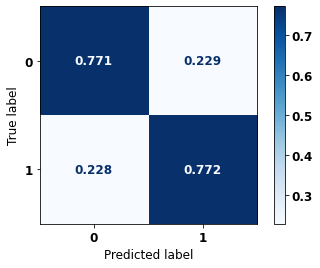


              precision    recall  f1-score   support

           0      0.855     0.771     0.811      3704
           1      0.660     0.772     0.711      2131

    accuracy                          0.771      5835
   macro avg      0.757     0.771     0.761      5835
weighted avg      0.783     0.771     0.774      5835



In [ ]:
# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

> Há uma melhora de acurácia em relação ao primeiro modelo testado, passando um pouco de 77%.

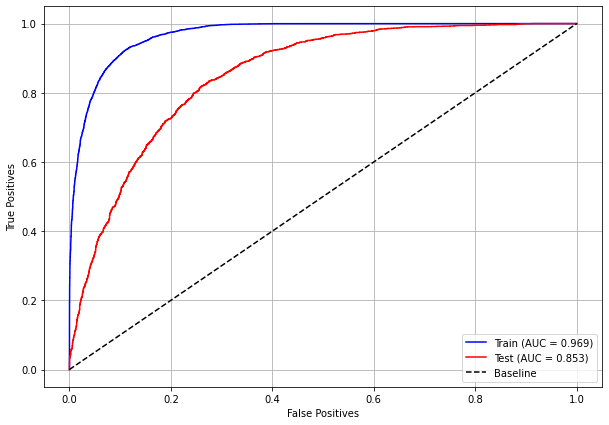

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui overfitting, pois para o conjunto de treino temos AUC = 0,969 e para o teste AUC = 0,853, essa diferença caracteriza o problema.

### **XGBoost**


O modelo XGBoost também terá alguns hiperparâmetros definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

* `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável `seed`.

* `max_depth`: será definido como 5, pois o padrão do modelo é 3 de profundidade máxima para as árvores, deixando o modelo muito simples.

* `scale_pos_weight`: usado para definir o peso da classe 1 no treinamento do modelo, pois temos classes desbalanceadas.

In [ ]:
# Criação e treinamento do modelo XGBoost 
xgboost = XGBClassifier(max_depth=5,
                        scale_pos_weight=1.273,
                        random_state=seed)

xgboost.fit(X_train, y_train)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=1.273)

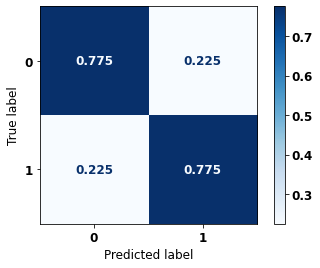


              precision    recall  f1-score   support

           0      0.857     0.775     0.814      3704
           1      0.665     0.775     0.716      2131

    accuracy                          0.775      5835
   macro avg      0.761     0.775     0.765      5835
weighted avg      0.787     0.775     0.778      5835



In [ ]:
# Matriz de confusão
plot_confusion_matrix(xgboost, X_test, y_test)

> A matriz obtida para o modelo XGBoost apresentou diagonal equilibrada em ambas as classes, com 77% de acurácia.


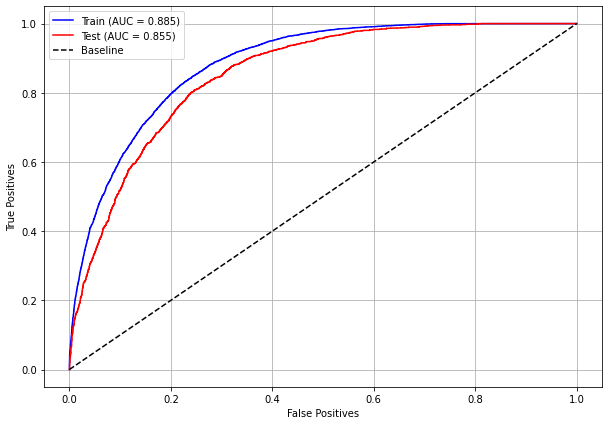

In [ ]:
# Curva ROC
plot_roc_curve(xgboost, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, 0,885 e 0,855 respectivamente, pode-se dizer que há apenas um pouco de overfitting, não sendo algo de grande preocupação.

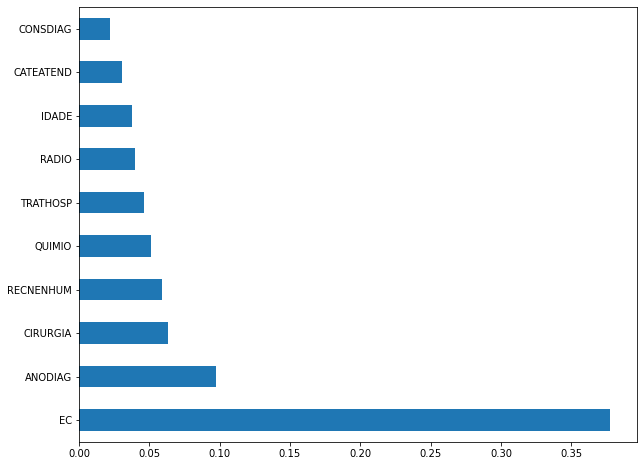

In [ ]:
# Importância das features
plot_feat_importances(xgboost, feat_cols)

> As features mais importantes nesta visualização são `EC`, com uma boa vantagem, `ANODIAG`, `CIRURGIA` e `RECNENHUM`. 

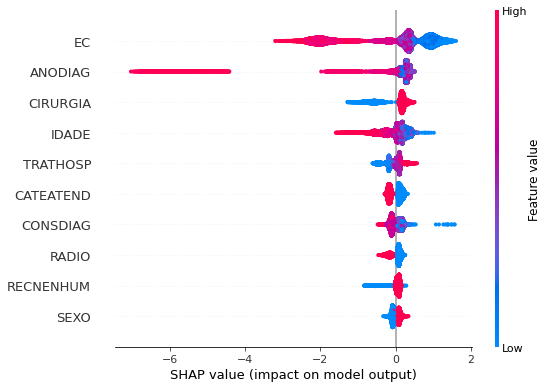

In [ ]:
# Importância das features pelo valores SHAP
plot_shap_values(xgboost, X_train, feat_cols)

A coluna `EC` foi a mais importante aqui também, com isso, os valores mais altos desta variável, mostrados em rosa, influenciaram mais o modelo na previsão da classe 0 (não sobreviveu ao quinto ano após o diagnóstico). Já os valores mais baixos desta coluna, em azul, tem mais peso para previsão ser da classe 1. Este comportamento faz sentido, pois quanto mais alto o estágio, maior é a extensão do câncer, assim menor a chance de sobrevivência.

O raciocínio para analisar as outras colunas é o mesmo utilizado para o estadiamento clínico.

#### Optuna

Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [ ]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators, 
                        max_depth=max_depth, 
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight, 
                        colsample_bytree=colsample_bytree,
                        random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100)

In [ ]:
# Melhor tentativa
print(f'The best trial is: \n{studyXGB.best_trial}')

The best trial is: 
FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.7602674638957018], datetime_start=datetime.datetime(2023, 1, 20, 18, 21, 19, 160025), datetime_complete=datetime.datetime(2023, 1, 20, 18, 21, 36, 287420), params={'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.15000000000000002, 'gamma': 0.2, 'min_child_weight': 4, 'colsample_bytree': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=0, value=None)


In [ ]:
# Melhor score
print(f'The best value is: \n{studyXGB.best_value}')

# Melhores parâmetros
print(f'The best parameters are: \n{studyXGB.best_params}')

The best value is: 
0.7602674638957018
The best parameters are: 
{'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.15000000000000002, 'gamma': 0.2, 'min_child_weight': 4, 'colsample_bytree': 0.4}


In [ ]:
plot_optimization_history(studyXGB).show()

In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.242

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.4, gamma=0.2,
              learning_rate=0.15000000000000002, min_child_weight=4,
              n_estimators=205, random_state=10, scale_pos_weight=1.242)

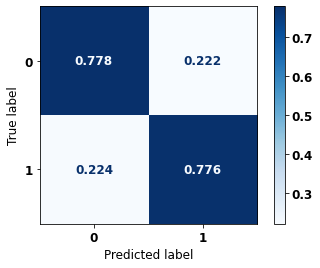


              precision    recall  f1-score   support

           0      0.858     0.778     0.816      3704
           1      0.668     0.776     0.718      2131

    accuracy                          0.777      5835
   macro avg      0.763     0.777     0.767      5835
weighted avg      0.788     0.777     0.780      5835



In [ ]:
# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

> Após a escolha dos hiperparâmetros, a acurácia do modelo otimizado aumentou um pouco em relação ao modelo inicial, de 77% para aproximadamente 78%.

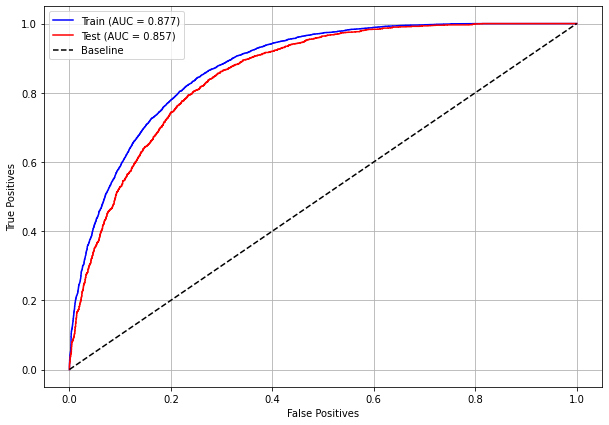

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui um pouco de overfitting, pois para o conjunto de treino temos AUC = 0,877 e para o teste AUC = 0,854, essa diferença caracteriza o problema.

### **LightGBM**


O modelo LightGBM também terá alguns hiperparâmetros definidos para obter um modelo base e depois será realizada a busca dos melhores parâmetros utilizando o Optuna.

Os parâmetros definidos para este primeiro modelo serão:

* `random_state`: para repetibilidade do treinamento do modelo. Será utilizado na busca pelos hiperparâmetros também, sempre como mesmo valor definido na variável `seed`.

* `max_depth`: será definido como 5, pois o padrão do modelo é 3 de profundidade máxima para as árvores, deixando o modelo muito simples.

* `class_weight`: usado para definir os pesos de cada classe no treinamento do modelo quando têm-se classes desbalanceadas.

In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=5, 
                      class_weight={0: 1, 1: 1.27},
                      random_state=seed)

lgbm.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 1, 1: 1.27}, max_depth=5, random_state=10)

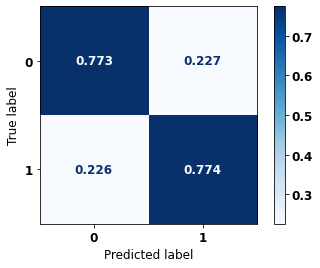


              precision    recall  f1-score   support

           0      0.856     0.773     0.812      3704
           1      0.662     0.774     0.714      2131

    accuracy                          0.773      5835
   macro avg      0.759     0.774     0.763      5835
weighted avg      0.785     0.773     0.776      5835



In [ ]:
# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

> A matriz obtida para o modelo LightGBM apresentou diagonal equilibrada em ambas as classes, com 77% de acurácia.


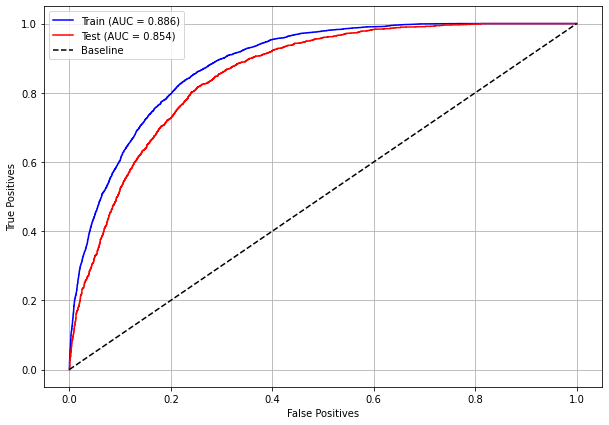

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

> Como a métrica AUC possui valores próximos para o conjunto de treino e de teste, 0,886 e 0,854 respectivamente, pode-se dizer que há apenas um pouco de overfitting.

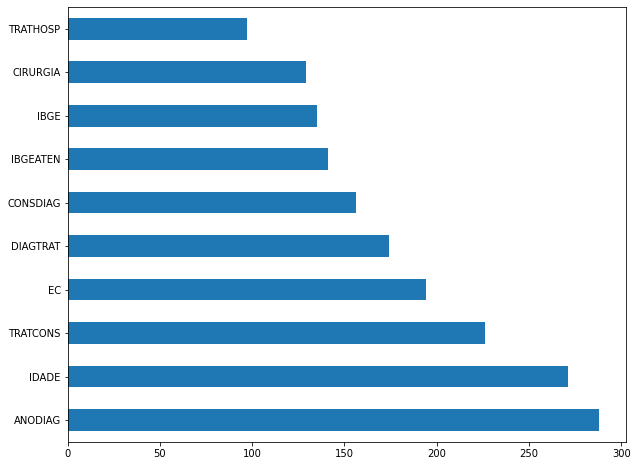

In [ ]:
# Importância das features
plot_feat_importances(lgbm, feat_cols)

> As features mais importantes nesta visualização são `ANODIAG`, `IDADE`, `TRATCONS` e `EC`. 

/usr/local/lib/python3.8/dist-packages/shap/explainers/_tree.py:353: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



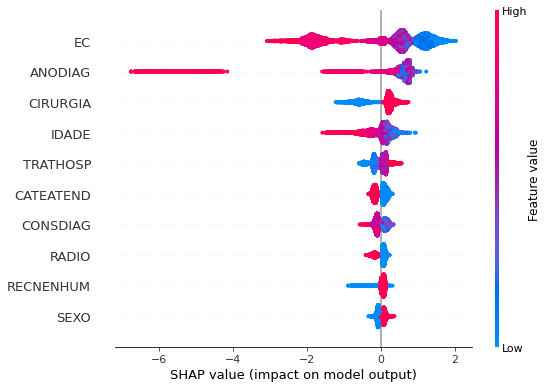

In [ ]:
# Importância das features pelo valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

A coluna `EC` foi a mais importante aqui também, com isso, os valores mais altos desta variável, mostrados em rosa, influenciaram mais o modelo na previsão da classe 0 (não sobreviveu ao quinto ano após o diagnóstico). Já os valores mais baixos desta coluna, em azul, tem mais peso para previsão ser da classe 1. Este comportamento faz sentido, pois quanto mais alto o estágio, maior é a extensão do câncer, assim menor a chance de sobrevivência.

O raciocínio para analisar as outras colunas é o mesmo utilizado para o estadiamento clínico.

#### Optuna

Para fazer a busca pelos melhores hiperparâmetros, será utilizado a biblioteca Optuna, definindo o intervalo para os parâmetros do modelo a serem buscados.

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

In [ ]:
# Função com o modelos e seus parâmetros, que terá sua métrica maximizada 
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 250)
    max_depth = trial.suggest_int('max_depth', 3, 18)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators, 
                         max_depth=max_depth, 
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed)

    return cross_val_score(cls, X_train, y_train, 
                           cv=skf, scoring='balanced_accuracy').mean()

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100)

In [ ]:
# Melhor tentativa
print(f'The best trial is: \n{studyLGBM.best_trial}')

The best trial is: 
FrozenTrial(number=63, state=TrialState.COMPLETE, values=[0.7612683072504737], datetime_start=datetime.datetime(2023, 1, 20, 19, 42, 9, 153423), datetime_complete=datetime.datetime(2023, 1, 20, 19, 42, 14, 534476), params={'n_estimators': 246, 'max_depth': 11, 'learning_rate': 0.060000000000000005, 'min_child_weight': 3, 'colsample_bytree': 0.3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=250, log=False, low=50, step=1), 'max_depth': IntDistribution(high=18, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=63, value=None)


In [ ]:
# Melhor score
print(f'The best value is: \n{studyLGBM.best_value}')

# Melhores parâmetros
print(f'The best parameters are: \n{studyLGBM.best_params}')

The best value is: 
0.7612683072504737
The best parameters are: 
{'n_estimators': 246, 'max_depth': 11, 'learning_rate': 0.060000000000000005, 'min_child_weight': 3, 'colsample_bytree': 0.3}


In [ ]:
plot_optimization_history(studyLGBM).show()

In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0: 1, 1: 1.315}

lgbm_optuna = LGBMClassifier()
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 1, 1: 1.315}, colsample_bytree=0.3,
               learning_rate=0.060000000000000005, max_depth=11,
               min_child_weight=3, n_estimators=246, random_state=10)

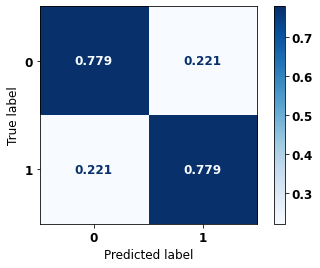


              precision    recall  f1-score   support

           0      0.859     0.779     0.817      3704
           1      0.669     0.779     0.720      2131

    accuracy                          0.779      5835
   macro avg      0.764     0.779     0.769      5835
weighted avg      0.790     0.779     0.782      5835



In [ ]:
# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

> Há uma melhora de acurácia em relação ao primeiro modelo testado, de 77% para 78%.

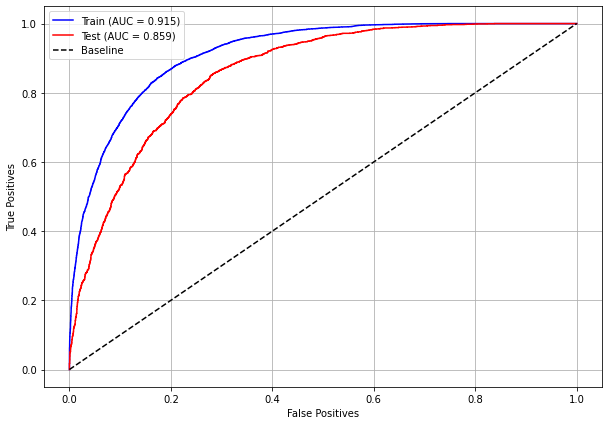

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui um pouco de overfitting, pois para o conjunto de treino temos AUC = 0,915 e para o teste AUC = 0,859, essa diferença caracteriza o problema.

### **Voting Classifier**


Usando os melhores modelos obtidos anteriormente, será criado um modelo de votação buscando obter um performance ainda melhor do que com os modelos sozinhos.

In [ ]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score}, Optuna = {optuna_score}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7674378748928877, Optuna = 0.7712082262210797

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgboost.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score}, Optuna = {optuna_score}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgboost.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7751499571550985, Optuna = 0.7772065124250214

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score}, Optuna = {optuna_score}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7734361610968294, Optuna = 0.7787489288774636

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 1.315}, colsample_bytree=0.3,
               learning_rate=0.060000000000000005, max_depth=11,
               min_child_weight=3, n_estimators=246, random_state=10)

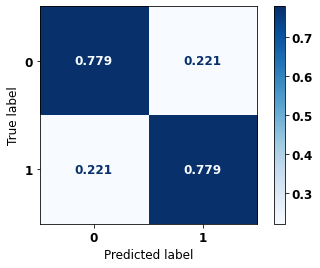


              precision    recall  f1-score   support

           0      0.860     0.779     0.817      3704
           1      0.670     0.779     0.720      2131

    accuracy                          0.779      5835
   macro avg      0.765     0.779     0.769      5835
weighted avg      0.790     0.779     0.782      5835



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('RandomForest', best_rf), 
                                   #('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ], 
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

> O modelo utilizando votação, com Random Forest e LightGBM, obteve resultados similares em relação aos modelos sozinhos, com 78% de acurácia.

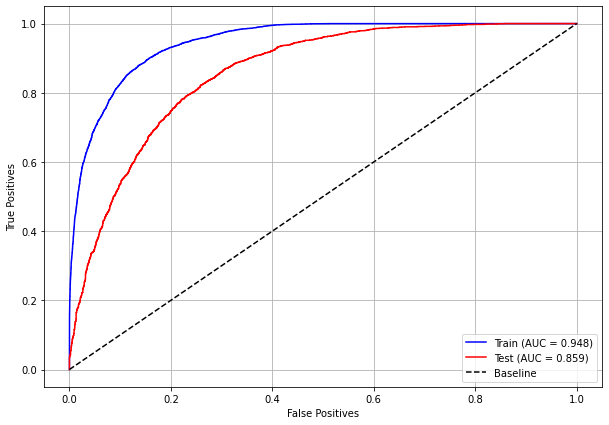

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

> A curva ROC mostra que o modelo possui overfitting, pois para o conjunto de treino temos AUC = 0,948 e para o teste AUC = 0,859.